Transfer Learning for Object Detection and Semantic Segmentation


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, color, data, exposure, transform, filters, util, metrics, feature
import cv2
from scipy.signal import convolve2d
from scipy.ndimage import uniform_filter
from PIL import Image

import torch
import torch.nn.functional as F
from tqdm import tqdm
import warnings

warnings.filterwarnings('ignore')
warnings.filterwarnings("ignore", message="Expected in:")
warnings.filterwarnings("ignore", message="libtorch_cpu.dylib")

print("Library versions:")
print("numpy:", np.__version__)
print("matplotlib:", plt.matplotlib.__version__)
print("cv2:", cv2.__version__)
print("pytorch:", torch.__version__)



Library versions:
numpy: 2.2.6
matplotlib: 3.10.3
cv2: 4.12.0
pytorch: 2.9.1+cu128


In [ ]:
import random

random.seed(2025)
# --- NumPy ---
np.random.seed(2025)
# --- PyTorch (CPU + GPU) ---
torch.manual_seed(2025)
torch.cuda.manual_seed(2025)

---

## <font color='#D85658'>1. Introduction and Setup</font> ##

Import pretrained models from `torchvision` or `Detectron2`, Load a few sample images (from COCO, Pascal VOC, or user-uploaded).


In this first exercise, we’ll prepare our environment for transfer learning experiments in **object detection** and **semantic segmentation**.

We will:
1. Import pretrained models from `torchvision` (or Detectron2 if available).  
2. Load and visualize a few sample images (from COCO, Pascal VOC, or user-uploaded).  
3. Prepare these images for inference.


In [ ]:
# --- Core libraries ---
import torch
from torchvision import models, transforms
from PIL import Image
import matplotlib.pyplot as plt
import requests
from io import BytesIO

# --- Check for GPU ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [ ]:
# --- Import pretrained models ---
# Faster R-CNN for object detection
model_detection = models.detection.fasterrcnn_resnet50_fpn(weights=models.detection.FasterRCNN_ResNet50_FPN_Weights.COCO_V1) # Faster R-CNN model with a ResNet-50-FPN backbone
model_detection.eval()

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [ ]:
# --- Import pretrained models ---
# DeepLabV3 for semantic segmentation
model_segmentation = models.segmentation.deeplabv3_resnet50(weights=models.segmentation.DeepLabV3_ResNet50_Weights.DEFAULT)  # DeepLabV3 model with a ResNet-50 backbone.
model_segmentation.eval()

DeepLabV3(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Se

- **Faster R-CNN** – for object detection (bounding boxes & class labels).
- **DeepLabV3** – for semantic segmentation (pixel-level classification).


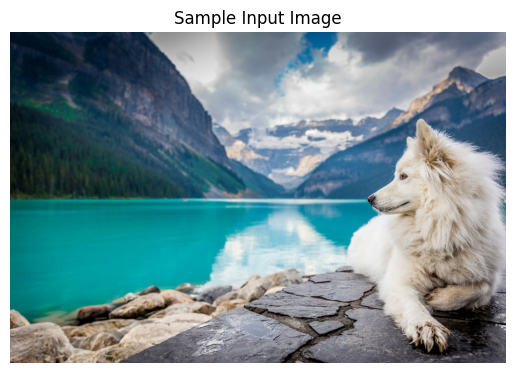

In [ ]:
url = "https://images.unsplash.com/photo-1504208434309-cb69f4fe52b0"
response = requests.get(url)
img = Image.open(BytesIO(response.content)).convert("RGB")  # Load the image in "RGB" format
# --- Display the image ---
plt.imshow(img)
plt.title("Sample Input Image")
plt.axis("off")
plt.show()

In [ ]:
# --- Define standard preprocessing pipeline ---
transform = transforms.Compose([
    transforms.ToTensor(),  # convert to tensor
])
# --- Apply transformation ---
input_tensor = transform(img)   # input_tensor shape: [3, H, W]
input_batch = input_tensor.unsqueeze(0)  # create batch dimension. input_batch shape: [1, 3, H, W]

#### Run a Quick Forward Pass

We can verify everything is working by running one forward pass through the detection model.


In [ ]:
# --- Perform inference with Faster R-CNN ---
with torch.no_grad():
    model_detection.to(device)
    predictions = model_detection(input_batch.to(device))[0]  # model_detection
# --- Inspect predicted boxes and labels ---
print("Detected objects:", len(predictions["boxes"]))
print("First 3 class IDs:", predictions["labels"][:3].tolist())
print("First 3 confidence scores:", predictions["scores"][:3].tolist())

Detected objects: 5
First 3 class IDs: [18, 23, 23]
First 3 confidence scores: [0.9962621331214905, 0.09108469635248184, 0.07058770209550858]


---

## <font color='#D85658'>2. Pre-trained Inference</font> ##

Pretrained models allow us to leverage powerful neural networks trained on large datasets (like COCO or ImageNet) without starting from scratch. In this section, you’ll perform inference using these models to automatically detect objects and segment scenes in new images.


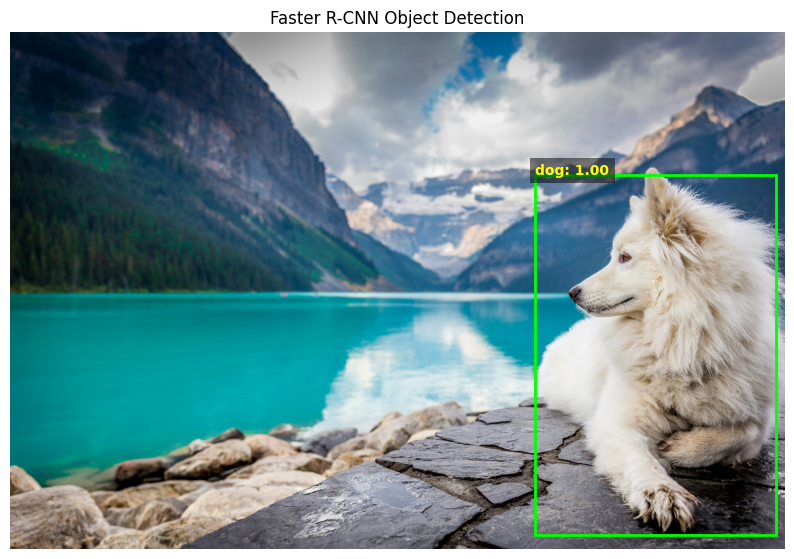

In [ ]:
import matplotlib.patches as patches
from torchvision.models.detection import FasterRCNN_ResNet50_FPN_Weights

# --- Get category labels for COCO dataset ---
# Torchvision provides label mappings for pretrained detection models
weights = FasterRCNN_ResNet50_FPN_Weights.COCO_V1  # Faster R-CNN model with a ResNet-50-FPN backbone
coco_labels = weights.meta["categories"]

# --- Run inference on the image ---
model_detection.eval()
with torch.no_grad():
    predictions = model_detection(input_batch.to(device))[0]

# --- Extract predicted boxes, labels, and confidence scores ---
boxes = predictions["boxes"].cpu().numpy()
labels = predictions["labels"].cpu().tolist()
scores = predictions["scores"].cpu().tolist()

# --- Display results ---
fig, ax = plt.subplots(1, figsize=(10, 8))
ax.imshow(img)
ax.set_title("Faster R-CNN Object Detection")
ax.axis("off")

# --- Draw bounding boxes for high-confidence detections ---
threshold = 0.6  # confidence threshold
for box, label, score in zip(boxes, labels, scores):
    if score >= threshold:
        x1, y1, x2, y2 = box
        rect = patches.Rectangle((x1, y1), x2 - x1, y2 - y1,
                                 linewidth=2, edgecolor='lime', facecolor='none')
        ax.add_patch(rect)
        ax.text(x1, y1 - 5, f"{coco_labels[label]}: {score:.2f}",
                color='yellow', fontsize=10, weight='bold',
                bbox=dict(facecolor='black', alpha=0.5, edgecolor='none'))

plt.show()

We use a pretrained DeepLabV3 model trained on the COCO dataset. This model predicts a segmentation mask where each pixel belongs to a class such as “person”, “car”, or “dog”.


In [ ]:
from torchvision.models.segmentation import deeplabv3_resnet50
from torchvision.models.segmentation import DeepLabV3_ResNet50_Weights

# --- Load pretrained DeepLabV3 model ---
weights = DeepLabV3_ResNet50_Weights.DEFAULT  # DeepLabV3 default weights
model_seg = deeplabv3_resnet50(weights=weights)  # Load DeepLabV3 model (with a ResNet-50 backbone)
model_seg.eval()

# --- Use the same preprocessing transform as the model expects ---
preprocess = weights.transforms()

# --- Load or reuse the same sample image ---
img_tensor = preprocess(img).unsqueeze(0)  # add batch dimension -> [1, 3, H, W]


We perform a forward pass through the model to get per-pixel class predictions, then extract the segmentation mask.


In [ ]:
# --- Run inference ---
with torch.no_grad():
    output = model_seg(img_tensor)['out']  # model returns a dict with "out" key

# --- Get predicted class per pixel (argmax over channels) ---
pred_mask = output.argmax(1).squeeze(0).cpu().numpy()


#### Visualize Segmentation Overlay

We’ll now overlay the segmentation mask on the original image using colors for each predicted class.


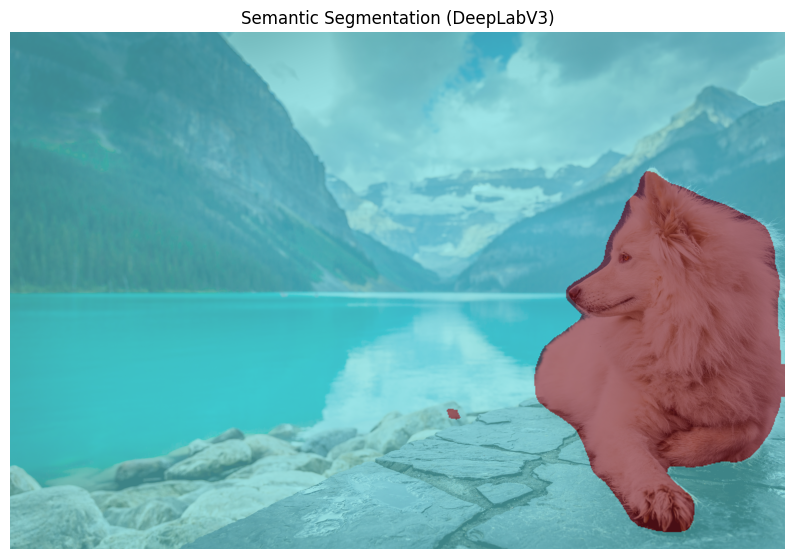

In [ ]:
# --- Use model's built-in color palette for visualization ---
# This palette maps each class ID to a color
colors = np.array(weights.meta["categories"])
num_classes = len(weights.meta["categories"])

# --- Generate a random colormap for visualizing mask ---
np.random.seed(42)
palette = np.random.randint(0, 255, (num_classes, 3), dtype=np.uint8)

# --- Create colorized segmentation mask ---
color_mask = palette[pred_mask % num_classes]

# --- Convert mask to a PIL image and resize to match original image ---
mask_img = Image.fromarray(color_mask).resize(img.size)
# --- Blend segmentation mask with the original image ---
blended = Image.blend(img.convert("RGBA"),mask_img.convert("RGBA"),alpha=0.6)  # convert img and mask_img to "RGBA". blend them with alpha = 0.6

# --- Display results ---
fig, ax = plt.subplots(1, figsize=(10, 8))
ax.imshow(blended)
ax.set_title("Semantic Segmentation (DeepLabV3)")
ax.axis("off")

plt.show()

---
## <font color='#D85658'>3. Transfer Learning</font> ##

Pretrained models already know general visual features (edges, textures, shapes) learned from large datasets like COCO or ImageNet.  
By reusing these features and retraining only the final layers on a smaller dataset, we can **achieve good performance quickly** — this is called *transfer learning*.

In this section, you will:
1. Create a small custom dataset (e.g., from Oxford-IIIT Pet dataset).  
2. Fine-tune a pretrained model for a few epochs.  
3. Compare **feature extraction** (frozen backbone) vs **full fine-tuning** (all layers trainable).


In [ ]:
from torchvision import datasets
from torch.utils.data import DataLoader, Subset, random_split
import os

In [ ]:
from torchvision.models.segmentation import deeplabv3_resnet50, DeepLabV3_ResNet50_Weights

# # --- Preprocessing using pretrained weights ---
weights = DeepLabV3_ResNet50_Weights.DEFAULT  # Load DeepLabV3 model (with a ResNet-50 backbone)
preprocess = weights.transforms()

# --- Define image transformations ---
transform = transforms.Compose([
      transforms.Resize((224,224)),# resize to fit pretrained models
      transforms.ToTensor(),# to tensor
      transforms.Normalize(mean=preprocess.mean,std=preprocess.std)# normalize
])

# Mask preprocessing (shift labels from {1,2,3} → {0,1,2})
def preprocess_mask(mask):
    mask = np.array(mask)
    mask = mask-1              # shift all labels down by 1
    mask = np.clip(mask,0,2)    # ensure values stay within [0,2]
    return torch.tensor(mask,dtype=torch.long)

target_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # resize to fit pretrained models
    transforms.Lambda(preprocess_mask)
])

root = "."

# --- Load Oxford-IIIT Pet segmentation dataset ---
full_dataset = datasets.OxfordIIITPet(
    root=root,
    split="trainval",

    target_types="segmentation",
    download=True,

    transform=transform,
    target_transform=target_transform
)

In [ ]:
# --- Randomly subset the dataset to max 500 images ---
max_samples = 500
indices = random.sample(range(len(full_dataset)), max_samples)
small_dataset = Subset(full_dataset, indices)

# --- Split into train/val sets (80% train / 20% val) ---
train_size = int(0.8*len(small_dataset))
val_size = len(small_dataset)-train_size
train_subset, val_subset = random_split(small_dataset,[train_size,val_size])

# --- DataLoaders ---
trainloader = DataLoader(train_subset, batch_size=2, shuffle=True)
valloader = DataLoader(val_subset, batch_size=2, shuffle=False)

print(f"Training samples: {len(train_subset)}, Validation samples: {len(val_subset)}")

Training samples: 400, Validation samples: 100


In [ ]:
from torchvision.models.segmentation import deeplabv3_resnet50, DeepLabV3_ResNet50_Weights
import torch.nn as nn

# --- Load pretrained DeepLabV3 ---
# --- Preprocessing using pretrained weights ---
weights = DeepLabV3_ResNet50_Weights.DEFAULT  # Load DeepLabV3 model (with a ResNet-50 backbone)
deeplabv3_model_1 = deeplabv3_resnet50(weights=weights)

# --- Oxford-IIIT Pet has 3 segmentation classes (background, pet, outline) ---
num_classes = 3
deeplabv3_model_1.classifier[4] = nn.Conv2d(256,num_classes,kernel_size=(1,1),stride=(1,1))  # build the last classifier layer

# --- Move to GPU if available ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
deeplabv3_model_1 = deeplabv3_model_1.to(device)

Build a function for model traninng.


In [ ]:
def train_segmentation(model, dataloader, optimizer, criterion, num_epochs=2, device="cpu", mode="Feature Extraction"):
    """
    Train a semantic segmentation model (e.g., DeepLabV3) with a progress bar.

    Args:
        model: The neural network model to train.
        dataloader: DataLoader providing (image, mask) pairs.
        optimizer: Optimizer (e.g., Adam) for updating model weights.
        criterion: Loss function (e.g., CrossEntropyLoss).
        num_epochs: Number of training epochs.
        device: 'cuda' or 'cpu' device to use for training.
        mode: A label indicating whether we're in 'Feature Extraction' or 'Full Fine-Tuning' mode.
    """

    print(f"🚀 Training Mode: {mode}")
    model.train()  # Set model to training mode (enables dropout, batchnorm updates)

    for epoch in range(num_epochs):
        running_loss = 0.0  # Track total loss for this epoch

        # tqdm creates a live progress bar for better visualization
        progress = tqdm(dataloader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=False)

        # Loop through batches of data
        for images, masks in progress:

            # --- Move data to the correct device ---
            images, masks = images.to(device),masks.to(device)

            # --- Reset gradient buffers before each iteration ---
            optimizer.zero_grad()

            # --- Forward pass: compute model predictions ---
            outputs = model(images)['out']  # DeepLabV3 returns a dict with key "out"

            # --- Compute pixel-wise cross-entropy loss ---
            loss = criterion(outputs,masks)

            # --- Backward pass: compute gradients ---
            loss.backward()

            # --- Update model parameters ---
            optimizer.step()

            # --- Accumulate running loss for reporting ---
            running_loss += loss.item()

            # --- Update progress bar with current batch loss ---
            progress.set_postfix(loss=loss.item())

        # --- Compute average loss per epoch ---
        epoch_loss = running_loss/len(dataloader)

        print(f"Epoch [{epoch+1}/{num_epochs}] | Loss: {epoch_loss:.4f}")

    print("✅ Training complete!")

In [ ]:
# --- Feature Extraction (Frozen Backbone) ---
for param in deeplabv3_model_1.parameters():
    param.requires_grad = False

for param in deeplabv3_model_1.classifier.parameters():
    param.requires_grad = True

# --- Define loss and optimizer ---
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(deeplabv3_model_1.classifier.parameters(),lr=0.001) # Adam, learning rate = 0.001

train_segmentation(deeplabv3_model_1, trainloader, optimizer, criterion, num_epochs=5, device=device, mode="Feature Extraction")

🚀 Training Mode: Feature Extraction


Epoch [1/5] | Loss: 0.4287


Epoch [2/5] | Loss: 0.3606


Epoch [3/5] | Loss: 0.3188


Epoch [4/5] | Loss: 0.3181


Epoch [5/5] | Loss: 0.2947
✅ Training complete!


Here, only the final classification layer is trained — the pretrained convolutional backbone is frozen, preserving its general feature representations.


In [ ]:
# --- Load pretrained DeepLabV3 ---
# --- Preprocessing using pretrained weights ---
weights = DeepLabV3_ResNet50_Weights.DEFAULT  # Load DeepLabV3 model (with a ResNet-50 backbone)
deeplabv3_model_2 = deeplabv3_resnet50(weights=weights)

# --- Oxford-IIIT Pet has 3 segmentation classes (background, pet, outline) ---
num_classes = 3
deeplabv3_model_2.classifier[4] = nn.Conv2d(256,num_classes,kernel_size=(1, 1),stride=(1, 1))  # build the last classifier layer

# --- Move to GPU if available ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
deeplabv3_model_2 = deeplabv3_model_2.to(device)

In [ ]:
### START CODE (3 lines) ###
# --- Full Fine-Tuning (All Layers Trainable) ---
for param in deeplabv3_model_2.parameters():
    param.requires_grad = True

optimizer = torch.optim.Adam(deeplabv3_model_2.parameters(),lr=1e-4)

train_segmentation(deeplabv3_model_2, trainloader, optimizer, criterion, num_epochs=5, device=device, mode="Full Fine-Tuning")

🚀 Training Mode: Full Fine-Tuning


Epoch [1/5] | Loss: 0.4751


Epoch [2/5] | Loss: 0.2944


Epoch [3/5] | Loss: 0.2449


Epoch [4/5] | Loss: 0.2102


Epoch [5/5] | Loss: 0.1832
✅ Training complete!


In [ ]:
from torchmetrics.classification import MulticlassJaccardIndex

# --- Initialize IoU metric ---
num_classes = 3
iou_metric = MulticlassJaccardIndex(num_classes=num_classes).to(device) # Move metric to the correct device


In [ ]:
# --- Evaluate IoU on validation set ---
def evaluate_segmentation(model, dataloader, device="cpu"):
    model.eval()
    iou_metric.reset()
    with torch.no_grad():
        for images, masks in dataloader:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)['out']
            preds = outputs.argmax(1)
            iou_metric.update(preds, masks)

    mean_iou = iou_metric.compute().item()
    mean_iou = mean_iou*100
    print(f"✅ Mean IoU: {mean_iou:.2f}")
    return mean_iou

In [ ]:
def compare_models(model_feature, model_finetune, dataloader, device="cpu"):
    """
    Compare feature extraction vs full fine-tuning models on the same test data.
    """
    acc_feat = evaluate_segmentation(model_feature,dataloader,device)  # evaluate_segmentation() on valloader
    acc_fine = evaluate_segmentation(model_finetune,dataloader,device)  # evaluate_segmentation() on valloader

    print("✅ Model Comparison Results:")
    print(f"Feature Extraction Accuracy : {acc_feat:.2f}%")
    print(f"Full Fine-Tuning Accuracy   : {acc_fine:.2f}%")

    # --- Visualization ---
    plt.figure(figsize=(6, 4))
    bars = plt.bar(["Feature Extraction", "Full Fine-Tuning"],
                   [acc_feat, acc_fine],
                   color=["#64B5F6", "#81C784"], width=0.6)
    plt.ylabel("Test Accuracy (%)")
    plt.title("Model Comparison: Transfer Learning Strategies")

    # Add numeric accuracy labels on top of bars
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, height + 0.5,
                 f"{height:.2f}%", ha='center', va='bottom',
                 fontsize=10, fontweight='bold')

    # Adjust y-axis to show subtle differences clearly
    plt.ylim(min(acc_feat, acc_fine) - 5, max(acc_feat, acc_fine) + 5)
    plt.grid(axis='y', linestyle='--', alpha=0.6)
    plt.show()

✅ Mean IoU: 68.32
✅ Mean IoU: 76.54
✅ Model Comparison Results:
Feature Extraction Accuracy : 68.32%
Full Fine-Tuning Accuracy   : 76.54%


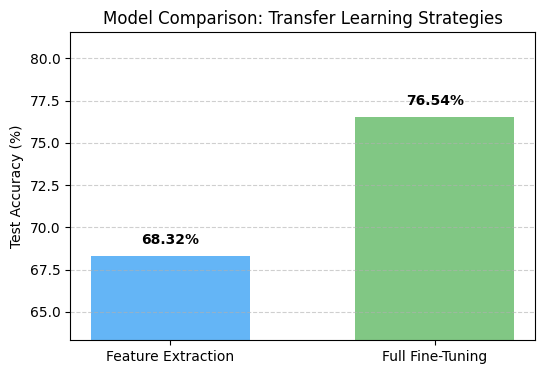

In [ ]:
# --- Compare both models on test set ---
compare_models(model_feature=deeplabv3_model_1,
               model_finetune=deeplabv3_model_2,
               dataloader=valloader,
               device=device)

**Reflection**

- How does accuracy and training speed differ between feature extraction and full fine-tuning?

- If your dataset were large and domain-specific (e.g., medical images), which strategy would you prefer?  

- In what situations might feature extraction be preferable over full fine-tuning?


---
## <font color='#D85658'>4. Evaluation</font> ##

So far, we’ve focused on accuracy for classification. However, for **object detection** and **semantic segmentation**, more specialized metrics are used:

1. **Mean Average Precision (mAP)** — measures how well predicted bounding boxes overlap with ground truth boxes across different confidence thresholds.

$\mathrm{mAP}=\frac{1}{N} \sum_{i=1}^N \mathrm{AP}_i$

Each AP (Average Precision) is computed as the area under the Precision–Recall (PR) curve:

$\mathrm{AP}=\int_0^1 p(r) d r$

Where:
- $N$ = number of object classes
- $p(r)$ = precision as a function of recall

2. **Intersection-over-Union (IoU)** — measures how well predicted segmentation masks align with true object regions.

$\mathrm{IoU}=\frac{\left|A_{\text {pred }} \cap A_{\mathrm{gt}}\right|}{\left|A_{\text {pred }} \cup A_{\mathrm{gt}}\right|}$

where:

- $A_{pred}$ = set of pixels (or area) predicted as the object

- $A_{gt}$ = set of pixels (or area) belonging to the ground truth object

- $\cap$ = intersection (overlapping area)

- $\cup$ = union (combined area of prediction and ground truth)

Interpretation:

- IoU = 1 $\rightarrow$ perfect overlap

- IoU = 0 $\rightarrow$ no overlap

In this exercise, you’ll implement simplified versions of both metrics to understand their core concepts.


In [ ]:
def compute_iou(boxA, boxB):
    """
    Compute Intersection-over-Union (IoU) between two bounding boxes.
    Each box = [x1, y1, x2, y2]
    """
    # Compute intersection
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])

    interArea = max(0,xB-xA) * max(0,yB-yA)
    # Compute union
    boxAArea = (boxA[2]-boxA[0]) * (boxA[3]-boxA[1])
    boxBArea = (boxB[2]-boxB[0]) * (boxB[3]-boxB[1])
    unionArea = boxAArea+boxBArea-interArea

    return interArea / unionArea if unionArea > 0 else 0

In [ ]:
def compute_map(pred_boxes, gt_boxes, iou_threshold=0.5):
    """
    Compute a simplified mean Average Precision (mAP) metric.
    pred_boxes and gt_boxes are lists of bounding boxes for one image.
    """
    matched = set()
    tp, fp = 0, 0

    for pred in pred_boxes:
        best_iou = 0
        best_gt = -1
        for i, gt in enumerate(gt_boxes):
            iou = compute_iou(pred, gt)
            if iou > best_iou:
                best_iou = iou
                best_gt = i
        if best_iou >= iou_threshold and best_gt not in matched:
            tp += 1
            matched.add(best_gt)
        else:
            fp += 1

    fn = len(gt_boxes)-len(matched)
    precision = tp/(tp+fp) if (tp+fp)>0 else 0
    recall = tp/(tp+fn) if (tp+fn)>0 else 0
    ap = (precision+recall)/2  # simple average, not integral
    return ap

In [ ]:
# --- Example: simulate predictions and ground truths ---
pred_boxes = [[50, 50, 200, 200], [30, 40, 100, 150]]  # predicted boxes
gt_boxes = [[48, 60, 198, 190]]  # ground truth

# --- Compute mAP at IoU threshold 0.5 ---
mAP = compute_map(pred_boxes, gt_boxes, iou_threshold=0.5)
print(f"Simplified mAP@0.5: {mAP:.3f}")

Simplified mAP@0.5: 0.750


In [ ]:
def compute_iou_mask(pred_mask, gt_mask):
    """
    Compute Intersection-over-Union for binary segmentation masks.
    pred_mask, gt_mask are numpy arrays of shape [H, W] with 0/1 values.
    """
    intersection = np.logical_and(pred_mask,gt_mask).sum()  # can use numpy logical_and()
    union = np.logical_or(pred_mask,gt_mask).sum()         # can use numpy logical_or()
    iou_out = intersection/union if union>0 else 0
    return iou_out

In [ ]:
# --- Example: Create dummy segmentation masks ---
gt_mask = np.zeros((100, 100), dtype=np.uint8)
gt_mask[30:70, 30:70] = 1  # ground truth region

pred_mask = np.zeros((100, 100), dtype=np.uint8)
pred_mask[35:75, 35:75] = 1  # predicted region (slightly shifted)

# --- Compute IoU ---
iou_score = compute_iou_mask(pred_mask, gt_mask)
print(f"Segmentation IoU: {iou_score:.3f}")

Segmentation IoU: 0.620


---

## <font color='#D85658'>5. Exercises</font> ##

In this final section, you'll apply what you've learned to extend and analyze CNN models.  
You will:

1. Modify the CNN architecture and observe how performance changes.  
2. Train on a binary classification subset to explore precision–recall trade-offs.  
3. Discuss why high accuracy doesn’t always mean good performance.

These exercises will help you connect architectural design, dataset setup, and metric interpretation.


📸 Upload your own image (e.g., a photo from your phone):


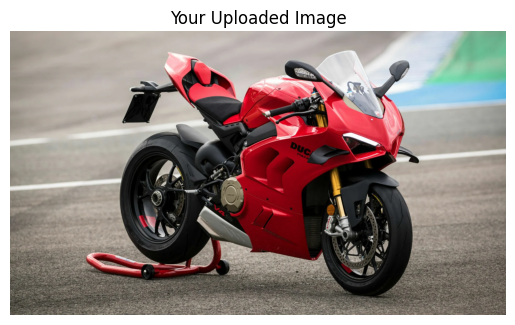

In [ ]:
# --- Load the first uploaded image ---
image_path = "/content/v4.jpeg"
img = Image.open(image_path).convert("RGB")

# --- Display the uploaded image ---
plt.imshow(img)
plt.title("Your Uploaded Image")
plt.axis("off")
plt.show()

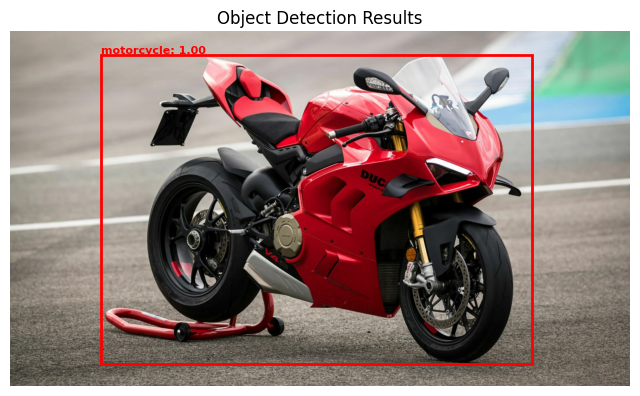

In [ ]:
# --- Load pretrained object detection model ---
det_model = models.detection.fasterrcnn_resnet50_fpn(weights=models.detection.FasterRCNN_ResNet50_FPN_Weights.COCO_V1).to(device)  # Faster R-CNN model with a ResNet-50-FPN backbone
det_model.eval()

# --- Define preprocessing and class labels ---
transform = transforms.Compose([
    transforms.ToTensor(),  # convert to tensor
])
weights = models.detection.FasterRCNN_ResNet50_FPN_Weights.COCO_V1
coco_labels = weights.meta["categories"]

# --- Apply transformation ---
input_tensor = transform(img).to(device)
input_batch = input_tensor.unsqueeze(0)  # create batch dimension

# --- Run detection inference ---
with torch.no_grad():
    preds = det_model(input_batch)[0]

# --- Extract predicted boxes, labels, and confidence scores ---
boxes = preds["boxes"].cpu().numpy()
labels = preds["labels"].cpu().tolist()
scores = preds["scores"].cpu().tolist()

# --- Visualize detections ---
fig, ax = plt.subplots(figsize=(8, 6))
ax.imshow(img)
for box, label, score in zip(boxes, labels, scores):
    if score > 0.5:  # Confidence threshold
        x1, y1, x2, y2 = box
        rect = patches.Rectangle((x1, y1), x2 - x1, y2 - y1,
                                 linewidth=2, edgecolor='red', facecolor='none')
        ax.add_patch(rect)
        ax.text(x1, y1 - 5, f"{coco_labels[label]}: {score:.2f}", color='red', fontsize=8, weight='bold')
ax.set_title("Object Detection Results")
ax.axis("off")
plt.show()

#### Prepare a Binary Dataset (Car vs Not-Car)


In [ ]:
# --- Define preprocessing transformations ---
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # resize (128,128)
    transforms.ToTensor(),  # to tensor
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))  # Normalize
])

# --- Load CIFAR-10 dataset ---
full_train = datasets.CIFAR10(root="./data", train=True, download=True, transform=transform)
full_test = datasets.CIFAR10(root="./data", train=False, download=True, transform=transform)

# --- Filter dataset to create "Car" vs "Not Car" binary classification ---
car_class = 1  # CIFAR-10 label for "automobile"

def binary_filter(dataset):
    """Convert CIFAR-10 to a binary (car vs not-car) dataset."""
    images, labels = [], []
    for img, label in dataset:
        images.append(img)
        labels.append(1 if label==car_class else 0)  # 1 = car, 0 = not car
    return list(zip(images, labels))

train_data = binary_filter(full_train)
test_data = binary_filter(full_test)

# --- Subset to make the dataset smaller ---
train_subset_idx = np.random.choice(len(train_data),1000,replace=False)  # train size = 1000
test_subset_idx = np.random.choice(len(test_data),500,replace=False)   # test size = 500

train_subset = [train_data[i] for i in train_subset_idx]
test_subset = [test_data[i] for i in test_subset_idx]

# --- DataLoaders ---
trainloader = DataLoader(train_subset, batch_size=32, shuffle=True)
testloader = DataLoader(test_subset, batch_size=32, shuffle=False)

print(f"✅ Small Binary Dataset Ready!")
print(f"Training samples: {len(train_subset)}, Test samples: {len(test_subset)}")

✅ Small Binary Dataset Ready!
Training samples: 1000, Test samples: 500


#### Load and Modify a Pretrained ResNet-18


In [ ]:
import torch.nn as nn
from torchvision.models import resnet18, ResNet18_Weights

# --- Load pretrained ResNet-18 model ---
weights = ResNet18_Weights.DEFAULT
resnet_model = resnet18(weights=weights)

# --- Replace the final layer for binary classification ---
num_features = resnet_model.fc.in_features
resnet_model.fc = nn.Linear(num_features,1)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnet_model = resnet_model.to(device)

print(resnet_model.fc)

Linear(in_features=512, out_features=1, bias=True)


Feature Extraction (Freeze Backbone).


In [ ]:
### START CODE (8 lines (4 for loops)) ###
# --- Freeze all convolutional layers (feature extractor) ---
for param in resnet_model.conv1.parameters():
    param.requires_grad = False
for param in resnet_model.layer1.parameters():
    param.requires_grad = False
for param in resnet_model.layer2.parameters():
    param.requires_grad = False
for param in resnet_model.layer3.parameters():
    param.requires_grad = False
for param in resnet_model.layer4.parameters():
    param.requires_grad = False
for param in resnet_model.maxpool.parameters():
    param.requires_grad = False
for param in resnet_model.bn1.parameters():
    param.requires_grad = False


criterion = nn.BCEWithLogitsLoss()  # Cross Entropy Loss
optimizer = torch.optim.Adam(resnet_model.fc.parameters(),lr=1e-3)  # Adam with learning rate = 1e-3

print("Training mode: Feature Extraction (Frozen Backbone)")

Training mode: Feature Extraction (Frozen Backbone)


#### Training Loop


In [ ]:
def train_model(model, dataloader, optimizer, criterion, num_epochs=3):
    model.train()
    for epoch in range(num_epochs):
        running_loss, correct, total = 0.0, 0, 0
        progress = tqdm(dataloader, desc=f"Epoch {epoch+1}/{num_epochs}")
        for inputs, labels in progress:
            inputs, labels = inputs.to(device),labels.to(device).float().unsqueeze(1)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            preds = (outputs > 0).long().squeeze(1)
            correct += (preds == labels.long().squeeze(1)).sum().item()
            total += labels.size(0)
            progress.set_postfix(loss=loss.item())
        print(f"Epoch {epoch+1}: Loss={running_loss/len(dataloader):.4f}, Acc={100*correct/total:.2f}%")

train_model(resnet_model, trainloader, optimizer, criterion, num_epochs=5)

Epoch 1/5:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 1/5:   0%|          | 0/32 [00:00<?, ?it/s, loss=0.763]

Epoch 1/5:   0%|          | 0/32 [00:00<?, ?it/s, loss=0.563]

Epoch 1/5:   0%|          | 0/32 [00:00<?, ?it/s, loss=0.478]

Epoch 1/5:   0%|          | 0/32 [00:00<?, ?it/s, loss=0.311]

Epoch 1/5:   0%|          | 0/32 [00:00<?, ?it/s, loss=0.462]

Epoch 1/5:   0%|          | 0/32 [00:00<?, ?it/s, loss=0.364]

Epoch 1/5:  19%|█▉        | 6/32 [00:00<00:00, 57.38it/s, loss=0.364]

Epoch 1/5:  19%|█▉        | 6/32 [00:00<00:00, 57.38it/s, loss=0.356]

Epoch 1/5:  19%|█▉        | 6/32 [00:00<00:00, 57.38it/s, loss=0.199]

Epoch 1/5:  19%|█▉        | 6/32 [00:00<00:00, 57.38it/s, loss=0.228]

Epoch 1/5:  19%|█▉        | 6/32 [00:00<00:00, 57.38it/s, loss=0.588]

Epoch 1/5:  19%|█▉        | 6/32 [00:00<00:00, 57.38it/s, loss=0.263]

Epoch 1/5:  19%|█▉        | 6/32 [00:00<00:00, 57.38it/s, loss=0.423]

Epoch 1/5:  19%|█▉        | 6/32 [00:00<00:00, 57.38it/s, loss=0.279]

Epoch 1/5:  19%|█▉        | 6/32 [00:00<00:00, 57.38it/s, loss=0.511]

Epoch 1/5:  19%|█▉        | 6/32 [00:00<00:00, 57.38it/s, loss=0.108]

Epoch 1/5:  19%|█▉        | 6/32 [00:00<00:00, 57.38it/s, loss=0.337]

Epoch 1/5:  19%|█▉        | 6/32 [00:00<00:00, 57.38it/s, loss=0.615]

Epoch 1/5:  19%|█▉        | 6/32 [00:00<00:00, 57.38it/s, loss=0.35] 

Epoch 1/5:  19%|█▉        | 6/32 [00:00<00:00, 57.38it/s, loss=0.113]

Epoch 1/5:  59%|█████▉    | 19/32 [00:00<00:00, 95.79it/s, loss=0.113]

Epoch 1/5:  59%|█████▉    | 19/32 [00:00<00:00, 95.79it/s, loss=0.245]

Epoch 1/5:  59%|█████▉    | 19/32 [00:00<00:00, 95.79it/s, loss=0.207]

Epoch 1/5:  59%|█████▉    | 19/32 [00:00<00:00, 95.79it/s, loss=0.214]

Epoch 1/5:  59%|█████▉    | 19/32 [00:00<00:00, 95.79it/s, loss=0.124]

Epoch 1/5:  59%|█████▉    | 19/32 [00:00<00:00, 95.79it/s, loss=0.297]

Epoch 1/5:  59%|█████▉    | 19/32 [00:00<00:00, 95.79it/s, loss=0.493]

Epoch 1/5:  59%|█████▉    | 19/32 [00:00<00:00, 95.79it/s, loss=0.444]

Epoch 1/5:  59%|█████▉    | 19/32 [00:00<00:00, 95.79it/s, loss=0.188]

Epoch 1/5:  59%|█████▉    | 19/32 [00:00<00:00, 95.79it/s, loss=0.338]

Epoch 1/5:  59%|█████▉    | 19/32 [00:00<00:00, 95.79it/s, loss=0.497]

Epoch 1/5:  59%|█████▉    | 19/32 [00:00<00:00, 95.79it/s, loss=0.437]

Epoch 1/5:  59%|█████▉    | 19/32 [00:00<00:00, 95.79it/s, loss=0.282]

Epoch 1/5:  59%|█████▉    | 19/32 [00:00<00:00, 95.79it/s, loss=0.633]

Epoch 1/5: 100%|██████████| 32/32 [00:00<00:00, 90.40it/s, loss=0.633]

Epoch 1/5: 100%|██████████| 32/32 [00:00<00:00, 88.16it/s, loss=0.633]

Epoch 1: Loss=0.3660, Acc=88.20%


Epoch 2/5:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 2/5:   0%|          | 0/32 [00:00<?, ?it/s, loss=0.112]

Epoch 2/5:   0%|          | 0/32 [00:00<?, ?it/s, loss=0.242]

Epoch 2/5:   0%|          | 0/32 [00:00<?, ?it/s, loss=0.159]

Epoch 2/5:   0%|          | 0/32 [00:00<?, ?it/s, loss=0.313]

Epoch 2/5:   0%|          | 0/32 [00:00<?, ?it/s, loss=0.189]

Epoch 2/5:   0%|          | 0/32 [00:00<?, ?it/s, loss=0.318]

Epoch 2/5:   0%|          | 0/32 [00:00<?, ?it/s, loss=0.205]

Epoch 2/5:   0%|          | 0/32 [00:00<?, ?it/s, loss=0.248]

Epoch 2/5:   0%|          | 0/32 [00:00<?, ?it/s, loss=0.287]

Epoch 2/5:   0%|          | 0/32 [00:00<?, ?it/s, loss=0.221]

Epoch 2/5:   0%|          | 0/32 [00:00<?, ?it/s, loss=0.152]

Epoch 2/5:   0%|          | 0/32 [00:00<?, ?it/s, loss=0.21] 

Epoch 2/5:   0%|          | 0/32 [00:00<?, ?it/s, loss=0.177]

Epoch 2/5:   0%|          | 0/32 [00:00<?, ?it/s, loss=0.312]

Epoch 2/5:  44%|████▍     | 14/32 [00:00<00:00, 119.53it/s, loss=0.312]

Epoch 2/5:  44%|████▍     | 14/32 [00:00<00:00, 119.53it/s, loss=0.227]

Epoch 2/5:  44%|████▍     | 14/32 [00:00<00:00, 119.53it/s, loss=0.51] 

Epoch 2/5:  44%|████▍     | 14/32 [00:00<00:00, 119.53it/s, loss=0.212]

Epoch 2/5:  44%|████▍     | 14/32 [00:00<00:00, 119.53it/s, loss=0.265]

Epoch 2/5:  44%|████▍     | 14/32 [00:00<00:00, 119.53it/s, loss=0.181]

Epoch 2/5:  44%|████▍     | 14/32 [00:00<00:00, 119.53it/s, loss=0.33] 

Epoch 2/5:  44%|████▍     | 14/32 [00:00<00:00, 119.53it/s, loss=0.233]

Epoch 2/5:  44%|████▍     | 14/32 [00:00<00:00, 119.53it/s, loss=0.412]

Epoch 2/5:  44%|████▍     | 14/32 [00:00<00:00, 119.53it/s, loss=0.232]

Epoch 2/5:  44%|████▍     | 14/32 [00:00<00:00, 119.53it/s, loss=0.333]

Epoch 2/5:  44%|████▍     | 14/32 [00:00<00:00, 119.53it/s, loss=0.187]

Epoch 2/5:  44%|████▍     | 14/32 [00:00<00:00, 119.53it/s, loss=0.167]

Epoch 2/5:  44%|████▍     | 14/32 [00:00<00:00, 119.53it/s, loss=0.231]

Epoch 2/5:  84%|████████▍ | 27/32 [00:00<00:00, 122.88it/s, loss=0.231]

Epoch 2/5:  84%|████████▍ | 27/32 [00:00<00:00, 122.88it/s, loss=0.12] 

Epoch 2/5:  84%|████████▍ | 27/32 [00:00<00:00, 122.88it/s, loss=0.207]

Epoch 2/5:  84%|████████▍ | 27/32 [00:00<00:00, 122.88it/s, loss=0.31] 

Epoch 2/5:  84%|████████▍ | 27/32 [00:00<00:00, 122.88it/s, loss=0.229]

Epoch 2/5:  84%|████████▍ | 27/32 [00:00<00:00, 122.88it/s, loss=0.111]

Epoch 2/5: 100%|██████████| 32/32 [00:00<00:00, 122.88it/s, loss=0.111]

Epoch 2: Loss=0.2388, Acc=90.60%


Epoch 3/5:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 3/5:   0%|          | 0/32 [00:00<?, ?it/s, loss=0.18]

Epoch 3/5:   0%|          | 0/32 [00:00<?, ?it/s, loss=0.148]

Epoch 3/5:   0%|          | 0/32 [00:00<?, ?it/s, loss=0.0974]

Epoch 3/5:   0%|          | 0/32 [00:00<?, ?it/s, loss=0.29]  

Epoch 3/5:   0%|          | 0/32 [00:00<?, ?it/s, loss=0.222]

Epoch 3/5:   0%|          | 0/32 [00:00<?, ?it/s, loss=0.28] 

Epoch 3/5:   0%|          | 0/32 [00:00<?, ?it/s, loss=0.228]

Epoch 3/5:   0%|          | 0/32 [00:00<?, ?it/s, loss=0.279]

Epoch 3/5:   0%|          | 0/32 [00:00<?, ?it/s, loss=0.277]

Epoch 3/5:   0%|          | 0/32 [00:00<?, ?it/s, loss=0.273]

Epoch 3/5:   0%|          | 0/32 [00:00<?, ?it/s, loss=0.326]

Epoch 3/5:   0%|          | 0/32 [00:00<?, ?it/s, loss=0.181]

Epoch 3/5:   0%|          | 0/32 [00:00<?, ?it/s, loss=0.159]

Epoch 3/5:  41%|████      | 13/32 [00:00<00:00, 128.94it/s, loss=0.159]

Epoch 3/5:  41%|████      | 13/32 [00:00<00:00, 128.94it/s, loss=0.159]

Epoch 3/5:  41%|████      | 13/32 [00:00<00:00, 128.94it/s, loss=0.233]

Epoch 3/5:  41%|████      | 13/32 [00:00<00:00, 128.94it/s, loss=0.135]

Epoch 3/5:  41%|████      | 13/32 [00:00<00:00, 128.94it/s, loss=0.188]

Epoch 3/5:  41%|████      | 13/32 [00:00<00:00, 128.94it/s, loss=0.213]

Epoch 3/5:  41%|████      | 13/32 [00:00<00:00, 128.94it/s, loss=0.227]

Epoch 3/5:  41%|████      | 13/32 [00:00<00:00, 128.94it/s, loss=0.209]

Epoch 3/5:  41%|████      | 13/32 [00:00<00:00, 128.94it/s, loss=0.222]

Epoch 3/5:  41%|████      | 13/32 [00:00<00:00, 128.94it/s, loss=0.126]

Epoch 3/5:  41%|████      | 13/32 [00:00<00:00, 128.94it/s, loss=0.132]

Epoch 3/5:  41%|████      | 13/32 [00:00<00:00, 128.94it/s, loss=0.194]

Epoch 3/5:  41%|████      | 13/32 [00:00<00:00, 128.94it/s, loss=0.111]

Epoch 3/5:  41%|████      | 13/32 [00:00<00:00, 128.94it/s, loss=0.151]

Epoch 3/5:  81%|████████▏ | 26/32 [00:00<00:00, 115.90it/s, loss=0.151]

Epoch 3/5:  81%|████████▏ | 26/32 [00:00<00:00, 115.90it/s, loss=0.132]

Epoch 3/5:  81%|████████▏ | 26/32 [00:00<00:00, 115.90it/s, loss=0.169]

Epoch 3/5:  81%|████████▏ | 26/32 [00:00<00:00, 115.90it/s, loss=0.0729]

Epoch 3/5:  81%|████████▏ | 26/32 [00:00<00:00, 115.90it/s, loss=0.0725]

Epoch 3/5:  81%|████████▏ | 26/32 [00:00<00:00, 115.90it/s, loss=0.252] 

Epoch 3/5:  81%|████████▏ | 26/32 [00:00<00:00, 115.90it/s, loss=0.0848]

Epoch 3/5: 100%|██████████| 32/32 [00:00<00:00, 118.81it/s, loss=0.0848]

Epoch 3: Loss=0.1882, Acc=92.30%


Epoch 4/5:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 4/5:   0%|          | 0/32 [00:00<?, ?it/s, loss=0.1]

Epoch 4/5:   0%|          | 0/32 [00:00<?, ?it/s, loss=0.0639]

Epoch 4/5:   0%|          | 0/32 [00:00<?, ?it/s, loss=0.14]  

Epoch 4/5:   0%|          | 0/32 [00:00<?, ?it/s, loss=0.165]

Epoch 4/5:   0%|          | 0/32 [00:00<?, ?it/s, loss=0.316]

Epoch 4/5:   0%|          | 0/32 [00:00<?, ?it/s, loss=0.203]

Epoch 4/5:   0%|          | 0/32 [00:00<?, ?it/s, loss=0.231]

Epoch 4/5:   0%|          | 0/32 [00:00<?, ?it/s, loss=0.054]

Epoch 4/5:   0%|          | 0/32 [00:00<?, ?it/s, loss=0.13] 

Epoch 4/5:   0%|          | 0/32 [00:00<?, ?it/s, loss=0.0846]

Epoch 4/5:   0%|          | 0/32 [00:00<?, ?it/s, loss=0.108] 

Epoch 4/5:   0%|          | 0/32 [00:00<?, ?it/s, loss=0.115]

Epoch 4/5:  38%|███▊      | 12/32 [00:00<00:00, 115.10it/s, loss=0.115]

Epoch 4/5:  38%|███▊      | 12/32 [00:00<00:00, 115.10it/s, loss=0.117]

Epoch 4/5:  38%|███▊      | 12/32 [00:00<00:00, 115.10it/s, loss=0.0681]

Epoch 4/5:  38%|███▊      | 12/32 [00:00<00:00, 115.10it/s, loss=0.155] 

Epoch 4/5:  38%|███▊      | 12/32 [00:00<00:00, 115.10it/s, loss=0.157]

Epoch 4/5:  38%|███▊      | 12/32 [00:00<00:00, 115.10it/s, loss=0.383]

Epoch 4/5:  38%|███▊      | 12/32 [00:00<00:00, 115.10it/s, loss=0.193]

Epoch 4/5:  38%|███▊      | 12/32 [00:00<00:00, 115.10it/s, loss=0.217]

Epoch 4/5:  38%|███▊      | 12/32 [00:00<00:00, 115.10it/s, loss=0.191]

Epoch 4/5:  38%|███▊      | 12/32 [00:00<00:00, 115.10it/s, loss=0.161]

Epoch 4/5:  38%|███▊      | 12/32 [00:00<00:00, 115.10it/s, loss=0.0969]

Epoch 4/5:  38%|███▊      | 12/32 [00:00<00:00, 115.10it/s, loss=0.149] 

Epoch 4/5:  38%|███▊      | 12/32 [00:00<00:00, 115.10it/s, loss=0.293]

Epoch 4/5:  38%|███▊      | 12/32 [00:00<00:00, 115.10it/s, loss=0.172]

Epoch 4/5:  78%|███████▊  | 25/32 [00:00<00:00, 122.77it/s, loss=0.172]

Epoch 4/5:  78%|███████▊  | 25/32 [00:00<00:00, 122.77it/s, loss=0.171]

Epoch 4/5:  78%|███████▊  | 25/32 [00:00<00:00, 122.77it/s, loss=0.139]

Epoch 4/5:  78%|███████▊  | 25/32 [00:00<00:00, 122.77it/s, loss=0.108]

Epoch 4/5:  78%|███████▊  | 25/32 [00:00<00:00, 122.77it/s, loss=0.176]

Epoch 4/5:  78%|███████▊  | 25/32 [00:00<00:00, 122.77it/s, loss=0.201]

Epoch 4/5:  78%|███████▊  | 25/32 [00:00<00:00, 122.77it/s, loss=0.142]

Epoch 4/5:  78%|███████▊  | 25/32 [00:00<00:00, 122.77it/s, loss=0.268]

Epoch 4/5: 100%|██████████| 32/32 [00:00<00:00, 123.14it/s, loss=0.268]

Epoch 4: Loss=0.1647, Acc=93.40%


Epoch 5/5:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 5/5:   0%|          | 0/32 [00:00<?, ?it/s, loss=0.127]

Epoch 5/5:   0%|          | 0/32 [00:00<?, ?it/s, loss=0.1]  

Epoch 5/5:   0%|          | 0/32 [00:00<?, ?it/s, loss=0.144]

Epoch 5/5:   0%|          | 0/32 [00:00<?, ?it/s, loss=0.173]

Epoch 5/5:   0%|          | 0/32 [00:00<?, ?it/s, loss=0.189]

Epoch 5/5:   0%|          | 0/32 [00:00<?, ?it/s, loss=0.129]

Epoch 5/5:   0%|          | 0/32 [00:00<?, ?it/s, loss=0.131]

Epoch 5/5:   0%|          | 0/32 [00:00<?, ?it/s, loss=0.154]

Epoch 5/5:   0%|          | 0/32 [00:00<?, ?it/s, loss=0.156]

Epoch 5/5:   0%|          | 0/32 [00:00<?, ?it/s, loss=0.171]

Epoch 5/5:   0%|          | 0/32 [00:00<?, ?it/s, loss=0.215]

Epoch 5/5:   0%|          | 0/32 [00:00<?, ?it/s, loss=0.111]

Epoch 5/5:   0%|          | 0/32 [00:00<?, ?it/s, loss=0.0709]

Epoch 5/5:  41%|████      | 13/32 [00:00<00:00, 123.73it/s, loss=0.0709]

Epoch 5/5:  41%|████      | 13/32 [00:00<00:00, 123.73it/s, loss=0.0984]

Epoch 5/5:  41%|████      | 13/32 [00:00<00:00, 123.73it/s, loss=0.181] 

Epoch 5/5:  41%|████      | 13/32 [00:00<00:00, 123.73it/s, loss=0.0811]

Epoch 5/5:  41%|████      | 13/32 [00:00<00:00, 123.73it/s, loss=0.0727]

Epoch 5/5:  41%|████      | 13/32 [00:00<00:00, 123.73it/s, loss=0.25]  

Epoch 5/5:  41%|████      | 13/32 [00:00<00:00, 123.73it/s, loss=0.317]

Epoch 5/5:  41%|████      | 13/32 [00:00<00:00, 123.73it/s, loss=0.166]

Epoch 5/5:  41%|████      | 13/32 [00:00<00:00, 123.73it/s, loss=0.0785]

Epoch 5/5:  41%|████      | 13/32 [00:00<00:00, 123.73it/s, loss=0.168] 

Epoch 5/5:  41%|████      | 13/32 [00:00<00:00, 123.73it/s, loss=0.0788]

Epoch 5/5:  41%|████      | 13/32 [00:00<00:00, 123.73it/s, loss=0.146] 

Epoch 5/5:  41%|████      | 13/32 [00:00<00:00, 123.73it/s, loss=0.109]

Epoch 5/5:  41%|████      | 13/32 [00:00<00:00, 123.73it/s, loss=0.0744]

Epoch 5/5:  81%|████████▏ | 26/32 [00:00<00:00, 116.92it/s, loss=0.0744]

Epoch 5/5:  81%|████████▏ | 26/32 [00:00<00:00, 116.92it/s, loss=0.115] 

Epoch 5/5:  81%|████████▏ | 26/32 [00:00<00:00, 116.92it/s, loss=0.181]

Epoch 5/5:  81%|████████▏ | 26/32 [00:00<00:00, 116.92it/s, loss=0.142]

Epoch 5/5:  81%|████████▏ | 26/32 [00:00<00:00, 116.92it/s, loss=0.154]

Epoch 5/5:  81%|████████▏ | 26/32 [00:00<00:00, 116.92it/s, loss=0.1]  

Epoch 5/5:  81%|████████▏ | 26/32 [00:00<00:00, 116.92it/s, loss=0.153]

Epoch 5/5: 100%|██████████| 32/32 [00:00<00:00, 120.54it/s, loss=0.153]

Epoch 5: Loss=0.1417, Acc=95.10%


#### Evaluate and Compare


In [ ]:
def evaluate_model(model, dataloader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device).long()
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1) if outputs.ndim > 1 else ((outputs > 0).long().squeeze(1))
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    acc = 100 * correct / total
    print(f"✅ Test Accuracy: {acc:.2f}%")
    return acc

evaluate_model(resnet_model, testloader)

✅ Test Accuracy: 89.20%


89.2

**Try the following experiments:**

1. Change the learning rate and observe how convergence changes.
2. Try freezing **only the first few layers**  instead of all.
3. Train for more epochs — do you see overfitting?
4. Replace “car” with another CIFAR-10 class.
5. Plot training and validation accuracy curves for comparison.


#### Try freezing **only the first few layers** (e.g., `layer1`–`layer2`) instead of all.


In [ ]:
# --- Load pretrained ResNet-18 model ---
weights = ResNet18_Weights.DEFAULT
resnet_model_few_layers = resnet18(weights=weights)
# --- Replace the final layer for binary classification ---
num_features = resnet_model_few_layers.fc.in_features
resnet_model_few_layers.fc = nn.Linear(num_features,1)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnet_model_few_layers = resnet_model_few_layers.to(device)

print(resnet_model_few_layers.fc)

Linear(in_features=512, out_features=1, bias=True)


In [ ]:
# --- Freeze all convolutional layers (feature extractor) ---
for param in resnet_model_few_layers.layer1.parameters():
    param.requires_grad = False
for param in resnet_model_few_layers.layer2.parameters():
    param.requires_grad = False
for param in resnet_model_few_layers.conv1.parameters():
    param.requires_grad = False
for param in resnet_model_few_layers.bn1.parameters():
    param.requires_grad = False

criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(resnet_model_few_layers.parameters(),lr=1e-3)

print("Training mode: Feature Extraction (Frozen layers 1 & 2)")

Training mode: Feature Extraction (Frozen layers 1 & 2)


#### Training Loop


In [ ]:
train_model(resnet_model_few_layers, trainloader, optimizer, criterion, num_epochs=5)

Epoch 1/5:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 1/5:   0%|          | 0/32 [00:00<?, ?it/s, loss=0.977]

Epoch 1/5:   0%|          | 0/32 [00:00<?, ?it/s, loss=0.751]

Epoch 1/5:   0%|          | 0/32 [00:00<?, ?it/s, loss=0.485]

Epoch 1/5:   0%|          | 0/32 [00:00<?, ?it/s, loss=0.505]

Epoch 1/5:   0%|          | 0/32 [00:00<?, ?it/s, loss=0.202]

Epoch 1/5:  16%|█▌        | 5/32 [00:00<00:00, 38.33it/s, loss=0.202]

Epoch 1/5:  16%|█▌        | 5/32 [00:00<00:00, 38.33it/s, loss=0.215]

Epoch 1/5:  16%|█▌        | 5/32 [00:00<00:00, 38.33it/s, loss=0.315]

Epoch 1/5:  16%|█▌        | 5/32 [00:00<00:00, 38.33it/s, loss=0.597]

Epoch 1/5:  16%|█▌        | 5/32 [00:00<00:00, 38.33it/s, loss=0.174]

Epoch 1/5:  16%|█▌        | 5/32 [00:00<00:00, 38.33it/s, loss=0.333]

Epoch 1/5:  16%|█▌        | 5/32 [00:00<00:00, 38.33it/s, loss=0.0426]

Epoch 1/5:  16%|█▌        | 5/32 [00:00<00:00, 38.33it/s, loss=0.207] 

Epoch 1/5:  38%|███▊      | 12/32 [00:00<00:00, 53.77it/s, loss=0.207]

Epoch 1/5:  38%|███▊      | 12/32 [00:00<00:00, 53.77it/s, loss=0.75] 

Epoch 1/5:  38%|███▊      | 12/32 [00:00<00:00, 53.77it/s, loss=0.0654]

Epoch 1/5:  38%|███▊      | 12/32 [00:00<00:00, 53.77it/s, loss=0.2]   

Epoch 1/5:  38%|███▊      | 12/32 [00:00<00:00, 53.77it/s, loss=0.102]

Epoch 1/5:  38%|███▊      | 12/32 [00:00<00:00, 53.77it/s, loss=0.746]

Epoch 1/5:  38%|███▊      | 12/32 [00:00<00:00, 53.77it/s, loss=0.131]

Epoch 1/5:  38%|███▊      | 12/32 [00:00<00:00, 53.77it/s, loss=0.0252]

Epoch 1/5:  38%|███▊      | 12/32 [00:00<00:00, 53.77it/s, loss=0.0231]

Epoch 1/5:  38%|███▊      | 12/32 [00:00<00:00, 53.77it/s, loss=0.0389]

Epoch 1/5:  66%|██████▌   | 21/32 [00:00<00:00, 68.59it/s, loss=0.0389]

Epoch 1/5:  66%|██████▌   | 21/32 [00:00<00:00, 68.59it/s, loss=0.0604]

Epoch 1/5:  66%|██████▌   | 21/32 [00:00<00:00, 68.59it/s, loss=0.162] 

Epoch 1/5:  66%|██████▌   | 21/32 [00:00<00:00, 68.59it/s, loss=0.276]

Epoch 1/5:  66%|██████▌   | 21/32 [00:00<00:00, 68.59it/s, loss=0.0479]

Epoch 1/5:  66%|██████▌   | 21/32 [00:00<00:00, 68.59it/s, loss=0.0685]

Epoch 1/5:  66%|██████▌   | 21/32 [00:00<00:00, 68.59it/s, loss=0.142] 

Epoch 1/5:  66%|██████▌   | 21/32 [00:00<00:00, 68.59it/s, loss=0.0439]

Epoch 1/5:  66%|██████▌   | 21/32 [00:00<00:00, 68.59it/s, loss=0.19]  

Epoch 1/5:  91%|█████████ | 29/32 [00:00<00:00, 72.70it/s, loss=0.19]

Epoch 1/5:  91%|█████████ | 29/32 [00:00<00:00, 72.70it/s, loss=0.479]

Epoch 1/5:  91%|█████████ | 29/32 [00:00<00:00, 72.70it/s, loss=0.0184]

Epoch 1/5:  91%|█████████ | 29/32 [00:00<00:00, 72.70it/s, loss=0.113] 

Epoch 1/5: 100%|██████████| 32/32 [00:00<00:00, 61.32it/s, loss=0.113]

Epoch 1: Loss=0.2652, Acc=90.00%


Epoch 2/5:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 2/5:   0%|          | 0/32 [00:00<?, ?it/s, loss=0.123]

Epoch 2/5:   0%|          | 0/32 [00:00<?, ?it/s, loss=0.211]

Epoch 2/5:   0%|          | 0/32 [00:00<?, ?it/s, loss=0.0181]

Epoch 2/5:   0%|          | 0/32 [00:00<?, ?it/s, loss=0.0347]

Epoch 2/5:   0%|          | 0/32 [00:00<?, ?it/s, loss=0.0987]

Epoch 2/5:   0%|          | 0/32 [00:00<?, ?it/s, loss=0.0225]

Epoch 2/5:   0%|          | 0/32 [00:00<?, ?it/s, loss=0.0379]

Epoch 2/5:   0%|          | 0/32 [00:00<?, ?it/s, loss=0.023] 

Epoch 2/5:   0%|          | 0/32 [00:00<?, ?it/s, loss=0.0484]

Epoch 2/5:  28%|██▊       | 9/32 [00:00<00:00, 87.88it/s, loss=0.0484]

Epoch 2/5:  28%|██▊       | 9/32 [00:00<00:00, 87.88it/s, loss=0.182] 

Epoch 2/5:  28%|██▊       | 9/32 [00:00<00:00, 87.88it/s, loss=0.184]

Epoch 2/5:  28%|██▊       | 9/32 [00:00<00:00, 87.88it/s, loss=0.0384]

Epoch 2/5:  28%|██▊       | 9/32 [00:00<00:00, 87.88it/s, loss=0.0192]

Epoch 2/5:  28%|██▊       | 9/32 [00:00<00:00, 87.88it/s, loss=0.117] 

Epoch 2/5:  28%|██▊       | 9/32 [00:00<00:00, 87.88it/s, loss=0.338]

Epoch 2/5:  28%|██▊       | 9/32 [00:00<00:00, 87.88it/s, loss=0.028]

Epoch 2/5:  28%|██▊       | 9/32 [00:00<00:00, 87.88it/s, loss=0.083]

Epoch 2/5:  28%|██▊       | 9/32 [00:00<00:00, 87.88it/s, loss=0.0725]

Epoch 2/5:  56%|█████▋    | 18/32 [00:00<00:00, 68.81it/s, loss=0.0725]

Epoch 2/5:  56%|█████▋    | 18/32 [00:00<00:00, 68.81it/s, loss=0.0287]

Epoch 2/5:  56%|█████▋    | 18/32 [00:00<00:00, 68.81it/s, loss=0.0507]

Epoch 2/5:  56%|█████▋    | 18/32 [00:00<00:00, 68.81it/s, loss=0.0877]

Epoch 2/5:  56%|█████▋    | 18/32 [00:00<00:00, 68.81it/s, loss=0.0139]

Epoch 2/5:  56%|█████▋    | 18/32 [00:00<00:00, 68.81it/s, loss=0.182] 

Epoch 2/5:  56%|█████▋    | 18/32 [00:00<00:00, 68.81it/s, loss=0.00526]

Epoch 2/5:  56%|█████▋    | 18/32 [00:00<00:00, 68.81it/s, loss=0.0104] 

Epoch 2/5:  56%|█████▋    | 18/32 [00:00<00:00, 68.81it/s, loss=0.0047]

Epoch 2/5:  81%|████████▏ | 26/32 [00:00<00:00, 62.92it/s, loss=0.0047]

Epoch 2/5:  81%|████████▏ | 26/32 [00:00<00:00, 62.92it/s, loss=0.169] 

Epoch 2/5:  81%|████████▏ | 26/32 [00:00<00:00, 62.92it/s, loss=0.0255]

Epoch 2/5:  81%|████████▏ | 26/32 [00:00<00:00, 62.92it/s, loss=0.12]  

Epoch 2/5:  81%|████████▏ | 26/32 [00:00<00:00, 62.92it/s, loss=0.0121]

Epoch 2/5:  81%|████████▏ | 26/32 [00:00<00:00, 62.92it/s, loss=0.104] 

Epoch 2/5:  81%|████████▏ | 26/32 [00:00<00:00, 62.92it/s, loss=0.431]

Epoch 2/5: 100%|██████████| 32/32 [00:00<00:00, 42.28it/s, loss=0.431]

Epoch 2: Loss=0.0914, Acc=97.40%


Epoch 3/5:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 3/5:   0%|          | 0/32 [00:00<?, ?it/s, loss=0.0168]

Epoch 3/5:   0%|          | 0/32 [00:00<?, ?it/s, loss=0.0118]

Epoch 3/5:   0%|          | 0/32 [00:00<?, ?it/s, loss=0.013] 

Epoch 3/5:   0%|          | 0/32 [00:00<?, ?it/s, loss=0.0414]

Epoch 3/5:   0%|          | 0/32 [00:00<?, ?it/s, loss=0.227] 

Epoch 3/5:   0%|          | 0/32 [00:00<?, ?it/s, loss=0.117]

Epoch 3/5:   0%|          | 0/32 [00:00<?, ?it/s, loss=0.0205]

Epoch 3/5:  22%|██▏       | 7/32 [00:00<00:00, 53.16it/s, loss=0.0205]

Epoch 3/5:  22%|██▏       | 7/32 [00:00<00:00, 53.16it/s, loss=0.02]  

Epoch 3/5:  22%|██▏       | 7/32 [00:00<00:00, 53.16it/s, loss=0.121]

Epoch 3/5:  22%|██▏       | 7/32 [00:00<00:00, 53.16it/s, loss=0.039]

Epoch 3/5:  22%|██▏       | 7/32 [00:00<00:00, 53.16it/s, loss=0.121]

Epoch 3/5:  22%|██▏       | 7/32 [00:00<00:00, 53.16it/s, loss=0.117]

Epoch 3/5:  22%|██▏       | 7/32 [00:00<00:00, 53.16it/s, loss=0.0136]

Epoch 3/5:  41%|████      | 13/32 [00:00<00:00, 46.53it/s, loss=0.0136]

Epoch 3/5:  41%|████      | 13/32 [00:00<00:00, 46.53it/s, loss=0.0183]

Epoch 3/5:  41%|████      | 13/32 [00:00<00:00, 46.53it/s, loss=0.0142]

Epoch 3/5:  41%|████      | 13/32 [00:00<00:00, 46.53it/s, loss=0.0685]

Epoch 3/5:  41%|████      | 13/32 [00:00<00:00, 46.53it/s, loss=0.0357]

Epoch 3/5:  41%|████      | 13/32 [00:00<00:00, 46.53it/s, loss=0.0411]

Epoch 3/5:  41%|████      | 13/32 [00:00<00:00, 46.53it/s, loss=0.23]  

Epoch 3/5:  41%|████      | 13/32 [00:00<00:00, 46.53it/s, loss=0.0902]

Epoch 3/5:  41%|████      | 13/32 [00:00<00:00, 46.53it/s, loss=0.0134]

Epoch 3/5:  66%|██████▌   | 21/32 [00:00<00:00, 58.67it/s, loss=0.0134]

Epoch 3/5:  66%|██████▌   | 21/32 [00:00<00:00, 58.67it/s, loss=0.0597]

Epoch 3/5:  66%|██████▌   | 21/32 [00:00<00:00, 58.67it/s, loss=0.0243]

Epoch 3/5:  66%|██████▌   | 21/32 [00:00<00:00, 58.67it/s, loss=0.0271]

Epoch 3/5:  66%|██████▌   | 21/32 [00:00<00:00, 58.67it/s, loss=0.0211]

Epoch 3/5:  66%|██████▌   | 21/32 [00:00<00:00, 58.67it/s, loss=0.0712]

Epoch 3/5:  66%|██████▌   | 21/32 [00:00<00:00, 58.67it/s, loss=0.00479]

Epoch 3/5:  66%|██████▌   | 21/32 [00:00<00:00, 58.67it/s, loss=0.0151] 

Epoch 3/5:  66%|██████▌   | 21/32 [00:00<00:00, 58.67it/s, loss=0.00981]

Epoch 3/5:  66%|██████▌   | 21/32 [00:00<00:00, 58.67it/s, loss=0.366]  

Epoch 3/5:  94%|█████████▍| 30/32 [00:00<00:00, 67.47it/s, loss=0.366]

Epoch 3/5:  94%|█████████▍| 30/32 [00:00<00:00, 67.47it/s, loss=0.173]

Epoch 3/5:  94%|█████████▍| 30/32 [00:00<00:00, 67.47it/s, loss=0.0586]

Epoch 3/5: 100%|██████████| 32/32 [00:00<00:00, 58.57it/s, loss=0.0586]

Epoch 3: Loss=0.0694, Acc=97.80%


Epoch 4/5:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 4/5:   0%|          | 0/32 [00:00<?, ?it/s, loss=0.0203]

Epoch 4/5:   0%|          | 0/32 [00:00<?, ?it/s, loss=0.0272]

Epoch 4/5:   0%|          | 0/32 [00:00<?, ?it/s, loss=0.0164]

Epoch 4/5:   9%|▉         | 3/32 [00:00<00:01, 17.97it/s, loss=0.0164]

Epoch 4/5:   9%|▉         | 3/32 [00:00<00:01, 17.97it/s, loss=0.0158]

Epoch 4/5:   9%|▉         | 3/32 [00:00<00:01, 17.97it/s, loss=0.016] 

Epoch 4/5:   9%|▉         | 3/32 [00:00<00:01, 17.97it/s, loss=0.0376]

Epoch 4/5:   9%|▉         | 3/32 [00:00<00:01, 17.97it/s, loss=0.0991]

Epoch 4/5:   9%|▉         | 3/32 [00:00<00:01, 17.97it/s, loss=0.0187]

Epoch 4/5:   9%|▉         | 3/32 [00:00<00:01, 17.97it/s, loss=0.107] 

Epoch 4/5:   9%|▉         | 3/32 [00:00<00:01, 17.97it/s, loss=0.0915]

Epoch 4/5:   9%|▉         | 3/32 [00:00<00:01, 17.97it/s, loss=0.0241]

Epoch 4/5:  34%|███▍      | 11/32 [00:00<00:00, 42.15it/s, loss=0.0241]

Epoch 4/5:  34%|███▍      | 11/32 [00:00<00:00, 42.15it/s, loss=0.0216]

Epoch 4/5:  34%|███▍      | 11/32 [00:00<00:00, 42.15it/s, loss=0.00997]

Epoch 4/5:  34%|███▍      | 11/32 [00:00<00:00, 42.15it/s, loss=0.0123] 

Epoch 4/5:  34%|███▍      | 11/32 [00:00<00:00, 42.15it/s, loss=0.0243]

Epoch 4/5:  34%|███▍      | 11/32 [00:00<00:00, 42.15it/s, loss=0.0151]

Epoch 4/5:  34%|███▍      | 11/32 [00:00<00:00, 42.15it/s, loss=0.0086]

Epoch 4/5:  34%|███▍      | 11/32 [00:00<00:00, 42.15it/s, loss=0.0593]

Epoch 4/5:  34%|███▍      | 11/32 [00:00<00:00, 42.15it/s, loss=0.014] 

Epoch 4/5:  34%|███▍      | 11/32 [00:00<00:00, 42.15it/s, loss=0.0328]

Epoch 4/5:  34%|███▍      | 11/32 [00:00<00:00, 42.15it/s, loss=0.00915]

Epoch 4/5:  66%|██████▌   | 21/32 [00:00<00:00, 61.83it/s, loss=0.00915]

Epoch 4/5:  66%|██████▌   | 21/32 [00:00<00:00, 61.83it/s, loss=0.0388] 

Epoch 4/5:  66%|██████▌   | 21/32 [00:00<00:00, 61.83it/s, loss=0.0155]

Epoch 4/5:  66%|██████▌   | 21/32 [00:00<00:00, 61.83it/s, loss=0.0117]

Epoch 4/5:  66%|██████▌   | 21/32 [00:00<00:00, 61.83it/s, loss=0.00196]

Epoch 4/5:  66%|██████▌   | 21/32 [00:00<00:00, 61.83it/s, loss=0.00193]

Epoch 4/5:  66%|██████▌   | 21/32 [00:00<00:00, 61.83it/s, loss=0.403]  

Epoch 4/5:  66%|██████▌   | 21/32 [00:00<00:00, 61.83it/s, loss=0.0142]

Epoch 4/5:  88%|████████▊ | 28/32 [00:00<00:00, 50.82it/s, loss=0.0142]

Epoch 4/5:  88%|████████▊ | 28/32 [00:00<00:00, 50.82it/s, loss=0.0124]

Epoch 4/5:  88%|████████▊ | 28/32 [00:00<00:00, 50.82it/s, loss=0.0858]

Epoch 4/5:  88%|████████▊ | 28/32 [00:00<00:00, 50.82it/s, loss=0.0764]

Epoch 4/5:  88%|████████▊ | 28/32 [00:00<00:00, 50.82it/s, loss=0.349] 

Epoch 4/5: 100%|██████████| 32/32 [00:00<00:00, 49.10it/s, loss=0.349]

Epoch 4: Loss=0.0529, Acc=98.30%


Epoch 5/5:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 5/5:   0%|          | 0/32 [00:00<?, ?it/s, loss=0.0156]

Epoch 5/5:   0%|          | 0/32 [00:00<?, ?it/s, loss=0.0217]

Epoch 5/5:   0%|          | 0/32 [00:00<?, ?it/s, loss=0.00235]

Epoch 5/5:   0%|          | 0/32 [00:00<?, ?it/s, loss=0.136]  

Epoch 5/5:   0%|          | 0/32 [00:00<?, ?it/s, loss=0.00303]

Epoch 5/5:   0%|          | 0/32 [00:00<?, ?it/s, loss=0.00653]

Epoch 5/5:   0%|          | 0/32 [00:00<?, ?it/s, loss=0.0119] 

Epoch 5/5:   0%|          | 0/32 [00:00<?, ?it/s, loss=0.00717]

Epoch 5/5:   0%|          | 0/32 [00:00<?, ?it/s, loss=0.00244]

Epoch 5/5:  28%|██▊       | 9/32 [00:00<00:00, 83.06it/s, loss=0.00244]

Epoch 5/5:  28%|██▊       | 9/32 [00:00<00:00, 83.06it/s, loss=0.00622]

Epoch 5/5:  28%|██▊       | 9/32 [00:00<00:00, 83.06it/s, loss=0.262]  

Epoch 5/5:  28%|██▊       | 9/32 [00:00<00:00, 83.06it/s, loss=0.0151]

Epoch 5/5:  28%|██▊       | 9/32 [00:00<00:00, 83.06it/s, loss=0.113] 

Epoch 5/5:  28%|██▊       | 9/32 [00:00<00:00, 83.06it/s, loss=0.0173]

Epoch 5/5:  28%|██▊       | 9/32 [00:00<00:00, 83.06it/s, loss=0.563] 

Epoch 5/5:  28%|██▊       | 9/32 [00:00<00:00, 83.06it/s, loss=0.00713]

Epoch 5/5:  28%|██▊       | 9/32 [00:00<00:00, 83.06it/s, loss=0.044]  

Epoch 5/5:  28%|██▊       | 9/32 [00:00<00:00, 83.06it/s, loss=0.0198]

Epoch 5/5:  56%|█████▋    | 18/32 [00:00<00:00, 65.45it/s, loss=0.0198]

Epoch 5/5:  56%|█████▋    | 18/32 [00:00<00:00, 65.45it/s, loss=0.0094]

Epoch 5/5:  56%|█████▋    | 18/32 [00:00<00:00, 65.45it/s, loss=0.0124]

Epoch 5/5:  56%|█████▋    | 18/32 [00:00<00:00, 65.45it/s, loss=0.25]  

Epoch 5/5:  56%|█████▋    | 18/32 [00:00<00:00, 65.45it/s, loss=0.0891]

Epoch 5/5:  56%|█████▋    | 18/32 [00:00<00:00, 65.45it/s, loss=0.0141]

Epoch 5/5:  56%|█████▋    | 18/32 [00:00<00:00, 65.45it/s, loss=0.0462]

Epoch 5/5:  56%|█████▋    | 18/32 [00:00<00:00, 65.45it/s, loss=0.0101]

Epoch 5/5:  78%|███████▊  | 25/32 [00:00<00:00, 45.41it/s, loss=0.0101]

Epoch 5/5:  78%|███████▊  | 25/32 [00:00<00:00, 45.41it/s, loss=0.0316]

Epoch 5/5:  78%|███████▊  | 25/32 [00:00<00:00, 45.41it/s, loss=0.0574]

Epoch 5/5:  78%|███████▊  | 25/32 [00:00<00:00, 45.41it/s, loss=0.0117]

Epoch 5/5:  78%|███████▊  | 25/32 [00:00<00:00, 45.41it/s, loss=0.0187]

Epoch 5/5:  78%|███████▊  | 25/32 [00:00<00:00, 45.41it/s, loss=0.0361]

Epoch 5/5:  78%|███████▊  | 25/32 [00:00<00:00, 45.41it/s, loss=0.00638]

Epoch 5/5:  78%|███████▊  | 25/32 [00:00<00:00, 45.41it/s, loss=0.0376] 

Epoch 5/5: 100%|██████████| 32/32 [00:00<00:00, 56.74it/s, loss=0.0376]

Epoch 5: Loss=0.0589, Acc=98.30%


In [ ]:
evaluate_model(resnet_model_few_layers, testloader)

✅ Test Accuracy: 89.20%


89.2